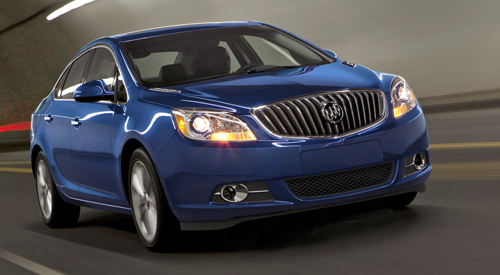

In [12]:
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept

cc = ChannelConcept()

device = "cuda:2" if torch.cuda.is_available() else "cpu"

model = net.to(device)
model.eval()

canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonPlusFlat(canonizers)

image = Image.open("../Datasets/stanfordCars/cars_test/cars_test/00011.jpg")
transform = T.Compose([T.Resize(256), T.CenterCrop(256), T.ToTensor()])
sample = transform(image).unsqueeze(0).to(device)
attribution = CondAttribution(model, no_param_grad=True)
image

In [1]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
from nets import PPCNet
basenet = resnet50(weights=ResNet50_Weights.DEFAULT)
num_parts, num_cls = 8, 196
net = PPCNet(basenet, num_parts, num_classes=num_cls)
net.load_state_dict(torch.load('stanfordCars/scar_p8_cluster.pt'))
print(f'model loaded')

model loaded


/tmp/ipykernel_475679/2088201617.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('stanfordCars/scar_p8_cluster.pt'))


In [7]:
p = model(sample)
p.argmax(dim=1)

tensor([48], device='cuda:0')

torch.Size([1, 256, 16, 16])


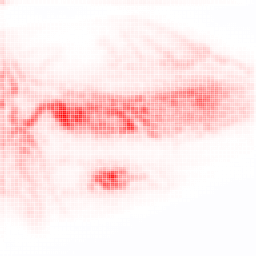

In [13]:
from crp.helper import get_layer_names
from crp.image import imgify

# compute heatmap wrt. output 46 (green lizard class)
conditions = [{'y':[48]}]

# zennit requires gradients
sample.requires_grad = True


# or use a dictionary for mask_map
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
mask_map = {name: cc.mask for name in layer_names}

softmax = torch.nn.Softmax(dim=-1)
def select_max(pred):
    id = softmax(pred).argmax(-1).item()
    print(f"wrt. class {id}")
    mask = torch.zeros_like(pred)
    mask[0, id] = pred[0, id]
    return mask
attr = attribution(sample, conditions, composite,  record_layer=layer_names)
print(attr.activations['proto_enc.0.0'].shape)
imgify(attr.heatmap, symmetric=True)

In [14]:
rel_c = cc.attribute(attr.relevances['proto_enc.0.0'], abs_norm=True)
print(rel_c[0].abs().sum())
rel_values, concept_ids = torch.topk(rel_c[0], 6)
concept_ids, rel_values*100

tensor(1., device='cuda:2')


(tensor([ 16, 227, 163, 244,  93, 141], device='cuda:2'),
 tensor([2.7561, 2.4053, 2.3763, 1.9878, 1.8308, 1.6795], device='cuda:2'))

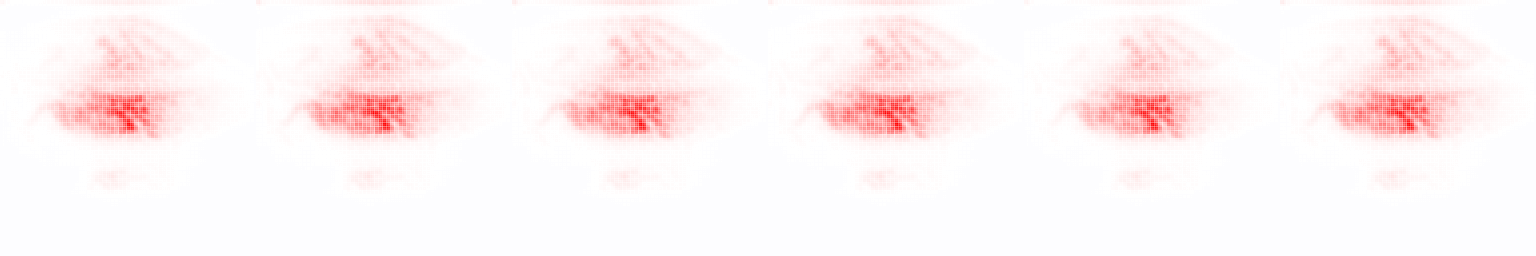

In [15]:
conditions = [{'proto_enc.0.0': [id], 'y': [48]} for id in concept_ids]
heatmap, _, _, _ = attribution(sample, conditions, composite)
imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)))

In [7]:
import importlib
import datasets
importlib.reload(datasets)
from datasets import S_CAR
dataset_val = S_CAR('../Datasets/stanfordCars', mode='test', image_size=256)


In [ ]:
from crp.visualization import FeatureVisualization
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

device = "cuda:2" if torch.cuda.is_available() else "cpu"
model = net.to(device)
model.eval()

attribution = CondAttribution(model)
cc = ChannelConcept()
layer_map = {layer : cc for layer in ['proto_enc.0.0', 'proto_enc.1.0', 'proto_enc.2.0',
                                      'proto_enc.3.0', 'proto_enc.4.0', 'proto_enc.5.0',
                                      'proto_enc.6.0', 'proto_enc.7.0']}
attribution = CondAttribution(model)

canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonPlusFlat(canonizers)

fv = FeatureVisualization(attribution, dataset_val, layer_map )
saved_files = fv.run(composite, 0, 1000, 32, 100)

Running Analysis...


100%|██████████| 32/32 [07:54<00:00, 14.84s/it]


100%|██████████| 1568/1568 [02:17<00:00, 11.38it/s]


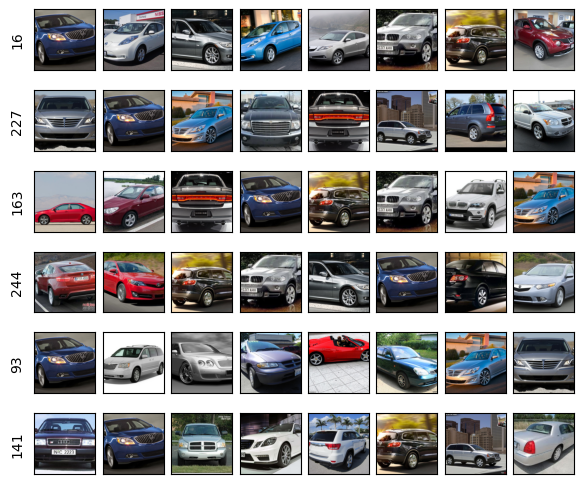

In [20]:
%matplotlib inline
from crp.image import plot_grid

ref_c = fv.get_max_reference(concept_ids.tolist(), "proto_enc.0.0", "relevance", (0, 8))

plot_grid(ref_c, figsize=(6, 5), padding=False)